# Functional Programming for Data Analysis

### Jim Pivarski

Second notebook: functional playground

C++ and Python are not functional languages.

Functional programming is a nebulously defined style, so there isn't a strict definition, but generally it involves working with expressions and not statements.

   * **Expression:** tree-like structure of nested function calls. Has a return value and can be used as an argument to a function. Examples: a FORTRAN formula, a diagrammed sentence, all of Lisp.
   * **Statement:** a command that either changes the computer's state or does nothing. Examples: Python's `for` and `if`, `move-robotic-arm`, all of assembly language.

This notebook will add methods to Python lists to make them easier to use for functional programming.

The goal will be to analyze data without ever writing a `for` loop or `if` statement.

In [1]:
%matplotlib inline
import helpers.functional

In [2]:
[1, 2, 3, 4, 5].map(lambda x: x**2)

[1, 4, 9, 16, 25]

To make it more real, let's work with real data (from the CMS public dataset).

In [11]:
from helpers.functional import events

events.take(1)

[Event([], [Muon(4.85949611664, -30.2398738861, 137.776489258, 141.139785767, -1, 0.0)], [], [], MET(-8.67440891266, 21.8987998962), 7)]

Before trying to solve problems, we have to understand our toolset. Here are some of the methods that we've added to list:

In [12]:
# not functional— a plain old function— but useful to peel off a few events to play with
events.take(2)

[Event([], [Muon(4.85949611664, -30.2398738861, 137.776489258, 141.139785767, -1, 0.0)], [], [], MET(-8.67440891266, 21.8987998962), 7),
 Event([], [Muon(-23.3766021729, -21.3244667053, -21.4867858887, 38.2477645874, 1, 0.518906891346)], [], [], MET(26.8287220001, 29.009141922), 7)]

In [13]:
# also not functional— but using a suffix rather than "len" makes it easier to read chains
events.take(12).size

12

In [14]:
# aha! a real functional! but does it matter what order I put the "map" and the "take"?
events.map(lambda ev: ev.muons).take(5)

[[Muon(4.85949611664, -30.2398738861, 137.776489258, 141.139785767, -1, 0.0)],
 [Muon(-23.3766021729, -21.3244667053, -21.4867858887, 38.2477645874, 1, 0.518906891346)],
 [],
 [],
 [Muon(21.0245990753, 15.2924814224, 38.0825500488, 46.1105804443, 1, 0.0)]]

Filter is a very important functional in high energy physics.

In [15]:
events.take(100).filter(lambda ev: ev.muons.size >= 2)

[Event([], [Muon(6.99902391434, -29.8159313202, -27.4981002808, 41.1598434448, -1, 0.564613461494), Muon(-3.35829114914, 27.4757556915, 40.1783943176, 48.7904701233, 1, 0.261090815067)], [], [], MET(10.4151391983, -3.97507190704), 4),
 Event([], [Muon(-26.7366104126, 10.1146039963, 3.76086854935, 28.8323936462, -1, 0.0), Muon(13.6701517105, 17.9857158661, -0.509090483189, 22.5971107483, 1, 2.00846838951)], [], [Photon(3.45673298836, -16.5644054413, 22.7657356262, 28.3656005859, 2.19763612747)], MET(13.8460693359, -5.43344545364), 4)]

Flatten turns pesky lists-of-lists into simple lists.

In [16]:
events.map(lambda ev: ev.muons).take(10)

[[Muon(4.85949611664, -30.2398738861, 137.776489258, 141.139785767, -1, 0.0)],
 [Muon(-23.3766021729, -21.3244667053, -21.4867858887, 38.2477645874, 1, 0.518906891346)],
 [],
 [],
 [Muon(21.0245990753, 15.2924814224, 38.0825500488, 46.1105804443, 1, 0.0)],
 [Muon(7.49188518524, -39.8153266907, 19.95195961, 45.1606063843, -1, 4.2009472847)],
 [Muon(-4.77304172516, 36.630443573, -77.6554260254, 85.9938812256, -1, 1.50938034058)],
 [Muon(-11.5234136581, -21.5348072052, 3.72992348671, 24.7074985504, 1, 1.42479777336)],
 [],
 []]

"Flatmap" does "map" and "flatten" at the same time. It's more than a convenience— it has foundational importance (see [monadic bind](https://en.wikipedia.org/wiki/Monad_%28functional_programming%29)). For our purposes, we can think of it as a way of turning event ntuples into particle ntuples.

In [17]:
events.flatmap(lambda ev: ev.muons).take(10)   # now a muon ntuple

[Muon(4.85949611664, -30.2398738861, 137.776489258, 141.139785767, -1, 0.0),
 Muon(-23.3766021729, -21.3244667053, -21.4867858887, 38.2477645874, 1, 0.518906891346),
 Muon(21.0245990753, 15.2924814224, 38.0825500488, 46.1105804443, 1, 0.0),
 Muon(7.49188518524, -39.8153266907, 19.95195961, 45.1606063843, -1, 4.2009472847),
 Muon(-4.77304172516, 36.630443573, -77.6554260254, 85.9938812256, -1, 1.50938034058),
 Muon(-11.5234136581, -21.5348072052, 3.72992348671, 24.7074985504, 1, 1.42479777336),
 Muon(-11.4520206451, 38.0730438232, -113.592842102, 120.349700928, -1, 1.3328255415),
 Muon(28.8080692291, -22.7943840027, -0.433953642845, 36.7381057739, -1, 2.78090119362),
 Muon(-40.2335548401, 56.5428123474, 106.151306152, 126.822471619, -1, 0.0),
 Muon(-45.6868629456, 10.3441486359, -30.7397556305, 56.0288734436, -1, 0.755304992199)]

"Reduce" is fundamentally different: it turns ntuples into aggregations (counts, sums, means, histograms...). All the other functionals we have seen so far turn ntuples into ntuples.

In [18]:
events.map(lambda ev: ev.numPrimaryVertices).take(1000) \
      .reduce(lambda x, y: x + y) / 1000.0

5.888

In [ ]:
def weightAndPrimaryVertices(ev):
    return (1.0, ev.numPrimaryVertices)

def averageOnTheFly(x, y):
    wx, x = x
    wy, y = y
    return (wx + wy), (wx*x + wy*y)/(wx + wy)

Reduce has a hidden limitation: it combines pairs of elements, using the result as part of the next pair. So what if you want to make an aggregation that is of a different type than the elements you're combining?

In [19]:
events.flatmap(lambda ev: ev.muons).take(2).reduce(lambda mu1, mu2: mu1.px + mu2.px)

-18.51710605621338

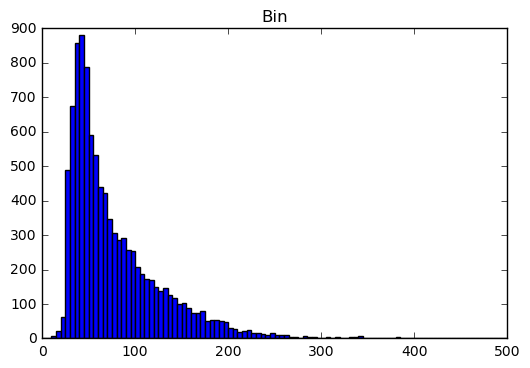

In [20]:
from histogrammar import *
from math import sqrt

hist = Bin(100, 0, 500, lambda muon: sqrt(muon.px**2 + muon.py**2 + muon.pz**2))

for muon in events.flatmap(lambda ev: ev.muons).take(10000):
    hist.fill(muon)     # not functional! this statement changes "hist"

hist.plot.matplotlib()

Well, there's an app for that.

In [21]:
def newhist():
    return Bin(100, 0, 500, lambda muon: sqrt(muon.px**2 + muon.py**2 + muon.pz**2))

def filled(histogram, muon):
    h = newhist()
    h.fill(muon)
    return histogram + h

events.flatmap(lambda ev: ev.muons).take(100).aggregate(filled, zero=newhist())   # functional (but slow)

<Bin num=100 low=0.0 high=500.0 values=Count underflow=Count overflow=Count nanflow=Count>

Generally, doing useful work with functional programming means being familiar with a toolset of handy combinators and knowing their mathematical properties.

Here's a nice one. Histogramming is important enough to be a standard combinator.

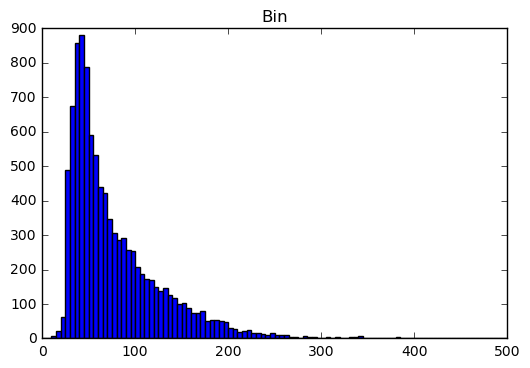

In [22]:
events.flatmap(lambda ev: ev.muons).take(10000) \
      .Bin(100, 0, 500, lambda muon: sqrt(muon.px**2 + muon.py**2 + muon.pz**2)) \
      .plot.matplotlib()

Taking away the `for` loop is like taking away `GOTO`. The programmer has less power but the code better expresses the programmer's intent.

Solving the domain-specific problem (physics) and optimizing the calculation are better separated. If you _want_ to think about performance issues, you edit the underlying library, not the physics code.

Guided challenge: the following shows how you can use nested `map` combinators to emulate a nested `for` loop. However, the output has too much structure— we can't plot it this way.

Eliminate the unwanted structure and make a plot of 1000 dimuon masses.

In [23]:
def dimuon(muon1, muon2):                # trick to map and filter in one function:
    if muon1 == muon2:
        return []                        # if the candidate doesn't pass cuts, return []
    else:
        return [(muon1 + muon2).mass]    # otherwise return singleton list

goodevents = events.filter(lambda ev: ev.muons.size > 1)

goodevents.map(lambda ev: ev.muons.map(lambda mu1: ev.muons.map(lambda mu2: dimuon(mu1, mu2)))).take(10)

[[[[], [88.9468251097268]], [[88.9468251097268], []]],
 [[[], [40.915272726635216]], [[40.915272726635216], []]],
 [[[], [89.88667775372531]], [[89.88667775372531], []]],
 [[[], [92.50889570173612]], [[92.50889570173612], []]],
 [[[], [87.33151684752877]], [[87.33151684752877], []]],
 [[[], [86.73589857883964]], [[86.73589857883964], []]],
 [[[], [17.215447985795976]], [[17.215447985795976], []]],
 [[[], [90.59405647767977]], [[90.59405647767977], []]],
 [[[], [99.54980031423942]], [[99.54980031423942], []]],
 [[[], [90.16057143550684]], [[90.16057143550684], []]]]

Of course, for something as common as nested `for` loops, we'd have standard combinators.

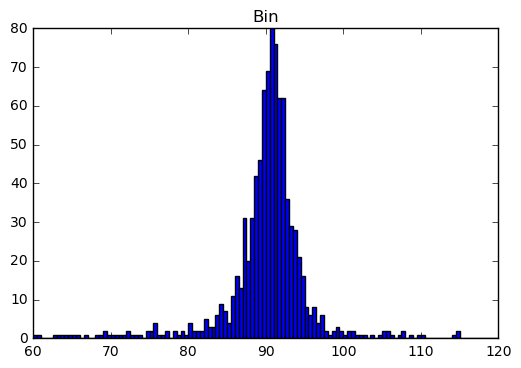

In [24]:
goodevents.flatmap(lambda ev: ev.muons.pairs(lambda mu1, mu2: (mu1 + mu2).mass)) \
          .take(1000).Bin(120, 60, 120, identity).plot.matplotlib()

Challenge: compute and plot `deltaR` for every muon-jet pair. (Don't use `for` loops!)

In [26]:
from math import *

def deltaphi(particle1, particle2):
    return (particle1.phi - particle2.phi) % (2*pi) - pi

def deltaeta(particle1, particle2):
    return particle1.eta - particle2.eta

def deltaR(particle1, particle2):
    return sqrt(deltaphi(particle1, particle2)**2 + deltaeta(particle1, particle2)**2)

goodevents = events.filter(lambda ev: ev.muons.size > 0 and ev.jets.size > 0).take(1000)

In [ ]:
# goodevents. ...?

In [27]:
help([].Bundle)

Help on function [...].UntypedLabel in [...]:

[...].UntypedLabel(*args, **kwds)
    Accumulate any number of aggregators of any type and label them with strings. Every sub-aggregator is filled with every input datum.
    
    This primitive simulates a directory of aggregators. For sub-directories, nest collections within the Bundle.
    
    Note that sub-aggregators within an Bundle may have *different types*. In strongly typed languages, this flexibility poses a problem: nested objects must be type-cast before they can be used. To collect objects of the *same type* with string-based look-up keys, use :doc:`Label <histogrammar.primitives.collection.Label>`.
    
    To collect aggregators of the *same type* without naming them, use :doc:`Index <histogrammar.primitives.collection.Index>`. To collect aggregators of *different types* without naming them, use :doc:`Branch <histogrammar.primitives.collection.Branch>`.

